In [0]:
import torch


In [2]:
#For Kaggle
from google.colab import files
import os
files.upload()
os.system("mkdir -p ~/.kaggle")
os.system("cp kaggle.json ~/.kaggle/")
os.system("chmod 600 ~/.kaggle/kaggle.json")

Saving kaggle.json to kaggle.json


0

In [3]:
!kaggle datasets download -d somnath796/detect-emotions-of-your-favorite-toons

 95% 88.0M/92.2M [00:04<00:00, 20.5MB/s]
100% 92.2M/92.2M [00:04<00:00, 22.6MB/s]


In [0]:
!unzip /content/detect-emotions-of-your-favorite-toons.zip

In [0]:
#Kaggle
filepath = "/content/frames/train_frames"
file_path_train = "/content/96714c94-6-Dataset/Dataset/Train.csv"
root_dir_train = "/content/frames/train_frames"

file_path_test = "/TestingData - Sheet1.csv"
root_dir_test = "/"
#PC
#filepath = "C:\\Users\\ACER\\Desktop\\EmotionDetection\\Dataset\\frames\\train_frames"
#file_path = pd.read_csv('C:\\Users\\ACER\\Desktop\\EmotionDetection\\Dataset\\Train.csv')
#root_dir =  "'C:\\Users\\ACER\\Desktop\\EmotionDetection\\Dataset\\frames\\train_frames"

In [0]:
import glob
image_list_train = glob.glob('/content/frames/train_frames/*.jpg')
image_list_test = glob.glob('/*.jpg')


In [0]:
encoder = {
    'happy': 0,
    'surprised' : 1,
    'angry': 2,
    'sad': 3,
    'Unknown': 4

}
decoder = {
    0 : 'happy',
    1 : 'surprised' ,
    2 : 'angry',
    3 : 'sad',
    4 : 'Unknown'

}

In [0]:
import albumentations as A
import torch 
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from skimage import io, transform
import pandas as pd
import matplotlib.pyplot as plt
from PIL import *

class classDataset(Dataset):
    def __init__(self, csv_file, root_dir, encoder, image_list, aug_list):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.images_file = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.encoder = encoder
        self.image_list = image_list
        self.aug = A.Compose([
        A.Resize(200, 300),
        A.CenterCrop(100, 100),
        A.RandomCrop(80, 80),
        A.HorizontalFlip(p=0.5),
        A.Rotate(limit=(-90, 90)),
        A.VerticalFlip(p=0.5),
        A.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        A.RandomBrightnessContrast(brightness_limit=0.05,contrast_limit=0.05,p=1),
        ])

    def __len__(self):
        return len(self.images_file)

    def __getitem__(self, idx):

        image = plt.imread(self.image_list[idx])
        image = Image.fromarray(image).convert('RGB')
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        label =  self.images_file.iloc[idx, 1]
        return torch.tensor(image, dtype=torch.float), self.encoder[label]
       
       



In [0]:
aug_list =[]
train_files = classDataset(file_path_train, root_dir_train, encoder,image_list_train, aug_list)
train_loader = DataLoader(train_files, shuffle = True, batch_size = 10)
test_files = classDataset(file_path_test, root_dir_test, encoder,image_list_test, aug_list)
test_loader = DataLoader(test_files, shuffle = True, batch_size = 10)

In [0]:
import numpy as np
def show_img(img):
    plt.figure(figsize=(20,20))
    # unnormalize
    img = img / 2 + 0.5  
    npimg = img.numpy()
    npimg = np.clip(npimg, 0., 1.)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

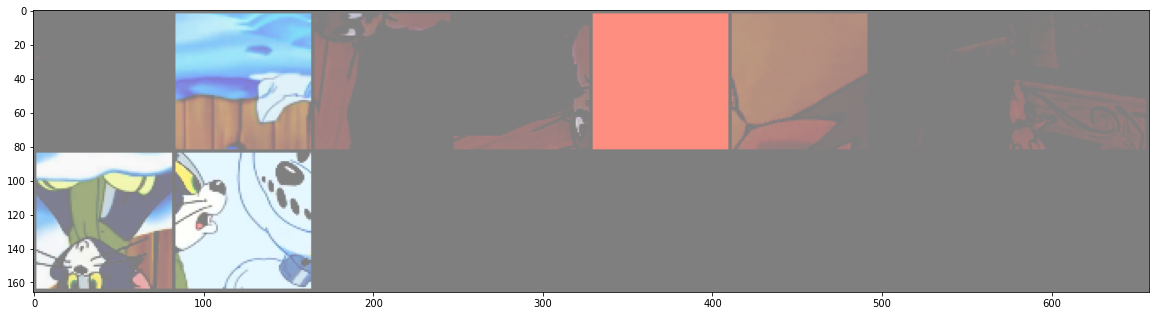

In [20]:
# show images
data = iter(train_loader)
images, labels = data.next()
from PIL import Image
show_img(torchvision.utils.make_grid(images))

In [0]:
from torch import nn
from torchvision import models
class classifie(nn.Module):
    def __init__(self, n_classes, pretrained = True ):
        super(classifie, self).__init__()
        self.cnn_arch = models.resnet18(pretrained = pretrained)
        self.linear1 = nn.Linear(1000,256)
        self.relu = nn.LeakyReLU()
        self.linear2 = nn.Linear(256,n_classes)
        #self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout(0.7)
   
    def forward(self, input):
        am = self.cnn_arch(input)
        x = self.dropout(self.relu(self.linear1(am)))
        x = self.linear2(x)
        return x

In [38]:
model = classifie(5).cuda()

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


In [0]:
import time
import sys
import torch.optim as optim

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

def train_epoch(model,epoch,data_loader):
    print('Training Epoch {}'.format(epoch))
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    accuracies = AverageMeter()
    start_time = time.time()
    end_time = time.time()
    t = []
    batch_size= 10
    criterion = nn.CrossEntropyLoss().cuda()
    optimizer = torch.optim.Adam(model.parameters(),lr = 1e-3)
    for i, (inputs, targets) in enumerate(data_loader):
        data_time.update(time.time() - end_time)
        if torch.cuda.is_available():
            targets = targets.type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
        outputs = model(inputs)    
        loss = criterion(outputs, targets.type(torch.cuda.LongTensor))
        acc = 100 * (outputs.detach().argmax(1) == targets).cpu().numpy().mean()
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        batch_time.update(time.time() - end_time)
        end_time = time.time()
        sys.stdout.write(
                "\r[Epoch %d] [Batch %d / %d] [Time %.2f %.2f] [Data %.2f %.2f] [Loss: %f, Acc: %.2f%%]"
                % (
                    epoch,
                    i,
                    len(data_loader),
                    batch_time.val,
                    batch_time.avg,
                    data_time.val,
                    data_time.avg,
                    losses.avg,
                    accuracies.avg))
        
        #print('\nEpoch time {} mins'.format((end_time-start_time)/60))
    
    states = {
        'state_dict': model.state_dict(),
        'optim_dict':optimizer.state_dict()
    }
    return losses.avg, accuracies.avg
   



In [40]:
epoch = 15
for i in range ( 0, epoch):
  value = train_epoch(model, i, train_loader)

Training Epoch 0
[Epoch 0] [Batch 29 / 30] [Time 0.16 0.20] [Data 0.14 0.17] [Loss: 2.547456, Acc: 24.16%]Training Epoch 1
[Epoch 1] [Batch 29 / 30] [Time 0.16 0.19] [Data 0.14 0.17] [Loss: 2.203699, Acc: 26.85%]Training Epoch 2
[Epoch 2] [Batch 29 / 30] [Time 0.16 0.19] [Data 0.14 0.17] [Loss: 1.923301, Acc: 30.20%]Training Epoch 3
[Epoch 3] [Batch 29 / 30] [Time 0.17 0.19] [Data 0.15 0.17] [Loss: 1.892901, Acc: 32.55%]Training Epoch 4
[Epoch 4] [Batch 29 / 30] [Time 0.16 0.19] [Data 0.14 0.17] [Loss: 1.753872, Acc: 28.19%]Training Epoch 5
[Epoch 5] [Batch 29 / 30] [Time 0.16 0.19] [Data 0.14 0.17] [Loss: 1.672364, Acc: 34.23%]Training Epoch 6
[Epoch 6] [Batch 29 / 30] [Time 0.15 0.19] [Data 0.13 0.17] [Loss: 1.661686, Acc: 32.89%]Training Epoch 7
[Epoch 7] [Batch 29 / 30] [Time 0.16 0.19] [Data 0.14 0.17] [Loss: 1.655552, Acc: 35.57%]Training Epoch 8
[Epoch 8] [Batch 29 / 30] [Time 0.16 0.19] [Data 0.14 0.17] [Loss: 1.684432, Acc: 35.91%]Training Epoch 9
[Epoch 9] [Batch 29 / 30] [Ti

In [0]:
PATH = '/content/model.pth'
torch.save(model.state_dict(), PATH)
model.load_state_dict(torch.load(PATH))
dataiter = iter(train_loader)
images, labels = dataiter.next()
images,labels = images.to('cuda'),labels.to('cuda')
outputs = model(images)

In [64]:
correct = 0
total = 0
with torch.no_grad():
    for data in train_loader:
        images, labels = data[0].to('cuda'), data[1].to('cuda')
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        #print(predicted, " " , labels)

print('Accuracy of the network test images: %d %%' % (
    100 * correct / total))
print(correct, " ", total)

Accuracy of the network test images: 38 %
116   298


In [66]:
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))
with torch.no_grad():
    for data in train_loader:
        images, labels = data
        images,labels = images.to('cuda'),labels.to('cuda')
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1

classes = ['happy', 'surprised', 'angry', 'sad', 'Unknown']
for i in range(5):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of happy :  0 %
Accuracy of surprised :  0 %
Accuracy of angry :  0 %
Accuracy of   sad :  0 %
Accuracy of Unknown : 97 %
